# HackerNews datat analysis challenge with Spark

In this notebook, you will analyse a dataset of (almost) all submitted HackerNews posts with Spark. Let's start by importing some of the libraries you will need.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
%matplotlib inline

The file has one JSON entry per line. In order to make accessing it easier, first turn each entry as a dictionary and use `persist()` to cache the resulting RDD.

In [ ]:
dataset_json = sc.textFile("HNStories.json")
dataset = dataset_json.map(lambda x: json.loads(x))
dataset.persist()

Finally, Spark has many helper functions on top of the ones we have studied which you will find useful. You can view them at [http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD)

### Task 1

Lets start with some initial analysis. 
* How many elements are in your datasets?
* What does the first element look like?

In [4]:
print dataset.count()

1333789


In [8]:
print dataset.take(1)

[{u'objectID': u'7815290', u'author': u'TuxLyn', u'url': u'https://duckduckgo.com/settings', u'num_comments': 0, u'created_at': u'2014-05-29T08:25:40Z', u'title': u'DuckDuckGo Settings', u'points': 1, u'created_at_i': 1401351940}]


Each element is a dictionary of attributes and their values for a post. Can you find the set of all attributes used throughout the RDD? The function `dictionary.keys()` gives you the list of attributes of a dictionary.

In [12]:
attributes = dataset.flatMap(lambda dictionary: dictionary.keys())
print attributes.take(5)

[u'objectID', u'title', u'url', u'num_comments', u'created_at']


We see that there are more attributes than just the one used in the first element. the function `compare_elems` below returns `True` if two elements have exactly the same set of attributes. Can you use it to count the number of elements which have the same set of attributes as the first element?

In [14]:
# Returns true if two elements have the same schema
def compare_elems(fist, second):
    if len(fist) != len(second):
        return False
    for key in fist.iterkeys():
        if key not in second:
            return False
    return True

In [ ]:
first = dataset.take(1)[0]
same = dataset.filter(lambda x: compare_elems(x, first)).persist()
print same.count()

We see that the vast majority of elements hold the same structure. In order to make this analysis easier, redefine `dataset` to only have elements which hold this structure.

In [20]:
dataset = same

All of the following tasks are optional, if you want to analyse the dataset in your own way using Spark feel free to do so! The tasks are there as a guide.

### Task 2: How many posts through time

The field `created_at_i` is very useful, it gives you a UNIX timestamp of the time at which the file was created. The following function lets you extract a time from a timestamp.

In [21]:
def extract_time(timestamp):
    return dt.fromtimestamp(timestamp)

Find the minimum and maximum timestamps in the RDD and call them `min_time` and `max_time`. These correspond to the first and last post, when did they occur?

In [33]:
times = dataset.map(lambda x: (x, extract_time(x['created_at_i']))).persist()
min_time1 = times.reduce(lambda x, y: x if x[1]<y[1] else y)


In [34]:
max_time1 = times.reduce(lambda x, y: x if x[1]>y[1] else y)

In [37]:
min_time = min_time1[0]['created_at_i']
max_time = max_time1[0]['created_at_i']

In [38]:
print min_time
print max_time

1160418111
1401351940


Now lets analyse how many elements through time. The following function assigns a record to one of 200 "buckets" of time. Use it to count the number of elements that fall within each bucket and call the result `bucket_rdd`. The result should be such that `buckets` below generates the corresponding output.

In [39]:
interval = (max_time - min_time + 1) / 200.0

def get_bucket(rec):
    return int((rec['created_at_i'] - min_time)/interval)

In [40]:
buckets_rdd = dataset.map(lambda x: (get_bucket(x), 1)) \
                       .reduceByKey(lambda x, y: x+y)

In [41]:
# Use this to test your result
buckets = sorted(buckets_rdd.collect())
print buckets

[(0, 46), (4, 1), (9, 265), (10, 703), (11, 696), (12, 183), (13, 870), (14, 940), (15, 865), (16, 657), (17, 653), (18, 610), (19, 545), (20, 594), (21, 755), (22, 879), (23, 979), (24, 936), (25, 996), (26, 470), (33, 1022), (34, 1712), (35, 1818), (36, 1691), (37, 2069), (38, 2258), (39, 2161), (40, 2210), (41, 2220), (42, 2210), (43, 2374), (44, 2377), (45, 2464), (46, 2536), (47, 2504), (48, 2427), (49, 2427), (50, 2379), (51, 2677), (52, 2511), (53, 2716), (54, 2555), (55, 2504), (56, 2645), (57, 2199), (58, 2437), (59, 2955), (60, 3155), (61, 3089), (62, 3031), (63, 3229), (64, 3066), (65, 2988), (66, 3399), (67, 3206), (68, 2995), (69, 3073), (70, 3083), (71, 652), (83, 2170), (84, 3339), (85, 4708), (86, 5191), (87, 5396), (88, 5436), (89, 5185), (90, 4880), (91, 4883), (92, 5623), (93, 5723), (94, 5784), (95, 5299), (96, 5176), (97, 5096), (98, 5403), (99, 5393), (100, 5486), (101, 5741), (102, 5639), (103, 6206), (104, 6508), (105, 6412), (106, 6716), (107, 7249), (108, 6922

In [19]:
#This is the desired output
buckets = sorted(buckets_rdd.collect())
print buckets

[(0, 46), (4, 1), (9, 270), (10, 763), (11, 762), (12, 211), (13, 1059), (14, 1078), (15, 957), (16, 749), (17, 721), (18, 685), (19, 664), (20, 831), (21, 1082), (22, 1152), (23, 1232), (24, 1191), (25, 1218), (26, 652), (33, 1134), (34, 1924), (35, 2047), (36, 1982), (37, 2453), (38, 2643), (39, 2487), (40, 2579), (41, 2630), (42, 2652), (43, 2805), (44, 2822), (45, 2975), (46, 3010), (47, 3031), (48, 2865), (49, 3018), (50, 3000), (51, 3301), (52, 3222), (53, 3166), (54, 3056), (55, 2967), (56, 3194), (57, 2660), (58, 2987), (59, 3575), (60, 3883), (61, 3733), (62, 3673), (63, 3901), (64, 3787), (65, 3653), (66, 4135), (67, 3977), (68, 3881), (69, 3998), (70, 3867), (71, 777), (83, 2534), (84, 4009), (85, 5552), (86, 6084), (87, 6297), (88, 6271), (89, 6040), (90, 5742), (91, 5761), (92, 6537), (93, 6656), (94, 6769), (95, 6262), (96, 6258), (97, 6132), (98, 6525), (99, 6606), (100, 6717), (101, 6972), (102, 6887), (103, 7602), (104, 7982), (105, 7979), (106, 8462), (107, 8614), (10

We can then use this to plot the number of submitted posts over time.

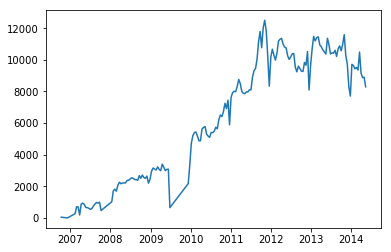

In [42]:
bs = [dt.fromtimestamp(x[0]*interval + min_time) for x in buckets]
ts = [x[1] for x in buckets]
plt.plot(bs, ts)

### Task 3

The following function gets the hour of the day at which a post was submitted. Use it to find the number of posts submitted at each hour of the day. The value of `hours_buckets` should match the one printed below.

In [43]:
def get_hour(rec):
    t = dt.fromtimestamp(rec['created_at_i'])
    return t.hour

In [50]:
hours_buckets_rdd = dataset.map(lambda x: (get_hour(x), 1)) \
                       .reduceByKey(lambda x, y: x+y).persist()

In [46]:
hours_buckets = sorted(hours_buckets_rdd.collect())
print hours_buckets

[(0, 40907), (1, 37250), (2, 35593), (3, 34334), (4, 32866), (5, 31178), (6, 29917), (7, 29659), (8, 29838), (9, 30411), (10, 30982), (11, 33751), (12, 40170), (13, 51026), (14, 63656), (15, 71246), (16, 75516), (17, 76325), (18, 74769), (19, 69759), (20, 64191), (21, 60992), (22, 54685), (23, 46224)]


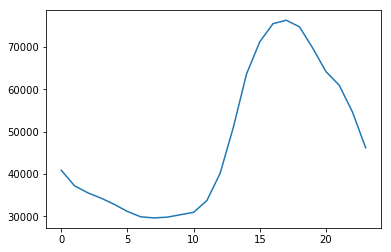

In [48]:
hrs = [x[0] for x in hours_buckets]
sz = [x[1] for x in hours_buckets]
plt.plot(hrs, sz)

### Task 4

The number of points scored by a post is under the attribute `points`. Use it to compute the average score received by submissions for each hour.

In [58]:
hours_buckets_rdd_total = dataset.map(lambda x: (get_hour(x), (x['points'], 1))) \
                       .reduceByKey(lambda x, y: (x[0]+y[0], x[1]+y[1])) \
                                      .mapValues(lambda x: x[0]/float(x[1])).persist()

In [59]:
scores_per_hour = sorted(hours_buckets_rdd_total.collect())
print scores_per_hour

[(0, 10.781064365512014), (1, 10.477020134228187), (2, 10.541707639142528), (3, 10.15346303955263), (4, 9.909115803565996), (5, 9.695169670921803), (6, 9.053548149881339), (7, 8.731616035604707), (8, 9.09940344527113), (9, 9.123672355397717), (10, 9.734135949906397), (11, 10.38046280110219), (12, 11.007667413492657), (13, 11.179829890643985), (14, 11.078547191152444), (15, 10.445133761895404), (16, 10.331161608136025), (17, 10.617622011136588), (18, 10.881862804103305), (19, 10.677848019610373), (20, 10.751413749591064), (21, 10.628705403987409), (22, 10.740568711712536), (23, 10.455499307718934)]


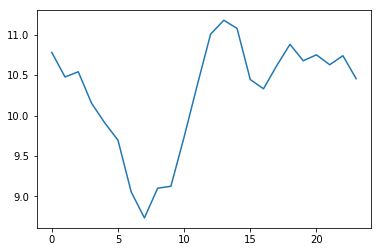

In [60]:
hrs = [x[0] for x in scores_per_hour]
sz = [x[1] for x in scores_per_hour]
plt.plot(hrs, sz)

It may be more useful to look at sucessful posts that get over 200 points. Find the proportion of posts that get above 200 points per hour.

In [65]:
prop_per_hour_rdd = dataset.map(lambda x: (get_hour(x), (x['points']>200, 1))) \
                       .reduceByKey(lambda x, y: (x[0]+y[0], x[1]+y[1])) \
                                      .mapValues(lambda x: x[0]/float(x[1])).persist()

In [64]:
prop_per_hour = sorted(prop_per_hour_rdd.collect())
print prop_per_hour

[(0, 0.008213753147383089), (1, 0.007704697986577181), (2, 0.007360997949034923), (3, 0.007572668491873944), (4, 0.00690683381001643), (5, 0.006863814227981269), (6, 0.0065514590366681155), (7, 0.006473583060790991), (8, 0.006870433675179302), (9, 0.007135575942915392), (10, 0.007520495771738429), (11, 0.007229415424728157), (12, 0.009061488673139158), (13, 0.009955708854309568), (14, 0.009331406308910394), (15, 0.008505740673160598), (16, 0.008739869696488161), (17, 0.008856862102849656), (18, 0.009375543340154342), (19, 0.008515030318668558), (20, 0.00847470829243975), (21, 0.008361752360965372), (22, 0.00832038036024504), (23, 0.0074203876773970235)]


In [75]:
prop_per_hour = sorted(prop_per_hour_rdd.collect())
print prop_per_hour

[(0, 0.00804263329014594), (1, 0.007624161073825503), (2, 0.007304807124996488), (3, 0.007514417195782606), (4, 0.006845980648694699), (5, 0.0067996664314580796), (6, 0.006484607413844971), (7, 0.006439866482349371), (8, 0.006870433675179302), (9, 0.007135575942915392), (10, 0.007423665354076561), (11, 0.007170157921246778), (12, 0.008961911874533234), (13, 0.00981852388978168), (14, 0.009221440241296971), (15, 0.008407489543272605), (16, 0.008620689655172414), (17, 0.008830658368817556), (18, 0.009335419759526007), (19, 0.008414684843532734), (20, 0.00839681575298718), (21, 0.008279774396642183), (22, 0.008174087958306665), (23, 0.007377120110764971)]


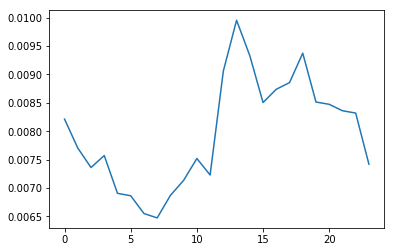

In [66]:
hrs = [x[0] for x in prop_per_hour]
sz = [x[1] for x in prop_per_hour]
plt.plot(hrs, sz)

### Task 5

The following function lists the word in the title. Use it to count the number of words in the title of each post, and look at the proportion of successful posts for each title length.

In [68]:
import re
def get_words(line):
    return re.compile('\w+').findall(line)

In [73]:
prop_per_title_length_rdd = dataset.map(lambda x: (len(get_words(x['title'])), (x['points']>200, 1))) \
                       .reduceByKey(lambda x, y: (x[0]+y[0], x[1]+y[1])) \
                                      .mapValues(lambda x: x[0]/float(x[1])).persist()

In [74]:
prop_per_title_length = sorted(prop_per_title_length_rdd.collect())
print prop_per_title_length

[(0, 0.0), (1, 0.016658619024625784), (2, 0.013314089843045282), (3, 0.010415626767828026), (4, 0.009991455425804614), (5, 0.009090595757147536), (6, 0.007303726150723017), (7, 0.007014673977084474), (8, 0.006785107191783278), (9, 0.006946688206785137), (10, 0.007041498025064612), (11, 0.007500127988532227), (12, 0.008508046655839362), (13, 0.01040870332255219), (14, 0.009316064530788457), (15, 0.013148371531966224), (16, 0.014405762304921969), (17, 0.0100418410041841), (18, 0.007751937984496124), (19, 0.006097560975609756), (20, 0.0), (21, 0.0), (22, 0.0), (23, 0.0), (24, 0.0), (25, 0.0), (26, 0.0), (27, 0.0), (28, 0.0), (29, 0.0), (30, 0.0), (36, 0.0), (38, 0.0)]


In [58]:
prop_per_title_length = sorted(prop_per_title_length_rdd.collect())
print prop_per_title_length

[(0, 0.0), (1, 0.016658619024625784), (2, 0.013314089843045282), (3, 0.010415626767828026), (4, 0.009991455425804614), (5, 0.009090595757147536), (6, 0.007303726150723017), (7, 0.007014673977084474), (8, 0.006785107191783278), (9, 0.006946688206785137), (10, 0.007041498025064612), (11, 0.007500127988532227), (12, 0.008508046655839362), (13, 0.01040870332255219), (14, 0.009316064530788457), (15, 0.013148371531966224), (16, 0.014405762304921969), (17, 0.0100418410041841), (18, 0.007751937984496124), (19, 0.006097560975609756), (20, 0.0), (21, 0.0), (22, 0.0), (23, 0.0), (24, 0.0), (25, 0.0), (26, 0.0), (27, 0.0), (28, 0.0), (29, 0.0), (30, 0.0), (36, 0.0), (38, 0.0)]


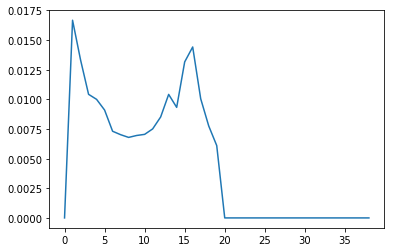

In [76]:
hrs = [x[0] for x in prop_per_title_length]
sz = [x[1] for x in prop_per_title_length]
plt.plot(hrs, sz)

Lets compare this with the distribution of number of words. Count for each title length the number of submissions with that length.

In [77]:
submissions_per_length_rdd = dataset.map(lambda x: (len(get_words(x['title'])), 1)) \
                       .reduceByKey(lambda x, y: x+y).persist()

In [78]:
submissions_per_length = sorted(submissions_per_length_rdd.collect())
print submissions_per_length

[(0, 1877), (1, 8284), (2, 27715), (3, 60102), (4, 87775), (5, 116054), (6, 135958), (7, 144269), (8, 139423), (9, 123800), (10, 102535), (11, 78132), (12, 54184), (13, 34010), (14, 17604), (15, 8290), (16, 3332), (17, 1195), (18, 387), (19, 164), (20, 65), (21, 33), (22, 8), (23, 13), (24, 12), (25, 7), (26, 7), (27, 2), (28, 1), (29, 3), (30, 2), (36, 1), (38, 1)]


In [66]:
submissions_per_length = sorted(submissions_per_length_rdd.collect())
print submissions_per_length

[(0, 1877), (1, 8284), (2, 27715), (3, 60102), (4, 87775), (5, 116054), (6, 135958), (7, 144269), (8, 139423), (9, 123800), (10, 102535), (11, 78132), (12, 54184), (13, 34010), (14, 17604), (15, 8290), (16, 3332), (17, 1195), (18, 387), (19, 164), (20, 65), (21, 33), (22, 8), (23, 13), (24, 12), (25, 7), (26, 7), (27, 2), (28, 1), (29, 3), (30, 2), (36, 1), (38, 1)]


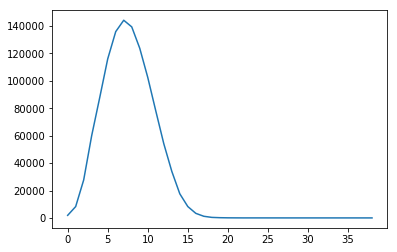

In [79]:
hrs = [x[0] for x in submissions_per_length]
sz = [x[1] for x in submissions_per_length]
plt.plot(hrs, sz)

Looks like most people are getting it wrong!

### Task 6

For this task, you will need a new function: `takeOrdered()`. Like `take()` it collects elements from an RDD. However, it can be applied the smalles elements. For example, `takeOrdered(10)` returns the 10 smallest elements. Furthermore, you can pass it a function to specify the way in which the elements should be ordered. For example, `takeOrdered(10, lambda x: -x)` will return the 10 largest elements.

The function below extracts the url domain out of a record. Use it to count the number of distinct domains posted to.

In [80]:
from urlparse import urlparse
def get_domain(rec):
    url = urlparse(rec['url']).netloc
    if url[0:4] == 'www.':
        return url[4:]
    else:
        return url
print get_domain(dataset.take(1)[0])

duckduckgo.com


In [83]:
distinctDomains = dataset.map(lambda x: (get_domain(x), 1)).reduceByKey(lambda x, y: x+y).persist()
print distinctDomains.count()

182515


Using `takeOrdered()` find the 25 most popular domains posted to.

In [84]:
top25 = distinctDomains.map(lambda x: (-x[1], x[0])).takeOrdered(25)

In [85]:
print top25

[(-22483, u'techcrunch.com'), (-16783, u'youtube.com'), (-16084, u'github.com'), (-14091, u'nytimes.com'), (-10654, u'arstechnica.com'), (-8332, u'wired.com'), (-6914, u'bbc.co.uk'), (-6291, u'medium.com'), (-5937, u'mashable.com'), (-5495, u'businessinsider.com'), (-5447, u'thenextweb.com'), (-5374, u'online.wsj.com'), (-5306, u'venturebeat.com'), (-5247, u'en.wikipedia.org'), (-5223, u'readwriteweb.com'), (-5050, u'forbes.com'), (-4931, u'gigaom.com'), (-4358, u'theverge.com'), (-4202, u'news.cnet.com'), (-3966, u'theatlantic.com'), (-3945, u'guardian.co.uk'), (-3827, u'economist.com'), (-3402, u'washingtonpost.com'), (-3287, u'engadget.com'), (-2994, u'technologyreview.com')]


In [73]:
print top25

[(u'techcrunch.com', 22483), (u'youtube.com', 16783), (u'github.com', 16084), (u'nytimes.com', 14091), (u'arstechnica.com', 10654), (u'wired.com', 8332), (u'bbc.co.uk', 6914), (u'medium.com', 6291), (u'mashable.com', 5937), (u'businessinsider.com', 5495), (u'thenextweb.com', 5447), (u'online.wsj.com', 5374), (u'venturebeat.com', 5306), (u'en.wikipedia.org', 5247), (u'readwriteweb.com', 5223), (u'forbes.com', 5050), (u'gigaom.com', 4931), (u'theverge.com', 4358), (u'news.cnet.com', 4202), (u'theatlantic.com', 3966), (u'guardian.co.uk', 3945), (u'economist.com', 3827), (u'washingtonpost.com', 3402), (u'engadget.com', 3287), (u'technologyreview.com', 2994)]


In [86]:
index = np.arange(25)
labels = [x[0] for x in top25]
counts = np.array([x[1] for x in top25]) * 100.0/dataset.count()
plt.xticks(index,labels, rotation='vertical')
plt.bar(index, counts, 0.5)

TypeError: ufunc 'multiply' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')

Create an pair RDD with 26 elements mapping each of these 25 popular domains with the average score received by the corresponding submissions as well as an `other` field for all submissions to other domains.

In [89]:
def map_to_domain(rec):
    domain = get_domain(rec)
    if domain in dict(top25):
        return domain
    else:
        return 'other'

In [ ]:
domain_av_score = domain_av_score_rdd.collect()
print domain_av_score

In [91]:
domain_av_score = domain_av_score_rdd.collect()
print domain_av_score

[(u'medium.com', 8.341281195358448), (u'gigaom.com', 8.187385925775704), (u'businessinsider.com', 4.3887170154686075), (u'forbes.com', 9.52990099009901), (u'mashable.com', 5.164392790971871), (u'theatlantic.com', 15.751386787695411), (u'thenextweb.com', 11.297411419129796), ('other', 10.436019477600967), (u'bbc.co.uk', 11.377928840034713), (u'economist.com', 11.029004442121767), (u'venturebeat.com', 7.508480964945345), (u'technologyreview.com', 8.105878423513694), (u'techcrunch.com', 12.69706000088956), (u'nytimes.com', 14.112696047122277), (u'online.wsj.com', 10.287309266840342), (u'youtube.com', 3.738127867484955), (u'news.cnet.com', 9.018086625416469), (u'arstechnica.com', 14.169326074713723), (u'en.wikipedia.org', 10.312750142938823), (u'github.com', 14.577095249937827), (u'washingtonpost.com', 17.386831275720166), (u'engadget.com', 8.233951931852753), (u'theverge.com', 4.373106929784305), (u'readwriteweb.com', 6.566724104920544), (u'guardian.co.uk', 5.3776932826362485), (u'wired.c

In [ ]:
index26 = np.arange(26)
labels = [x[0] for x in top25]
labels.append('other')
vals = np.array([dict(domain_av_score)[x] for x in labels])
plt.xticks(index26, labels, rotation='vertical')
plt.bar(index26, vals, 0.5)

Now compute the proportion of successes for each domain (over 200 points).

In [ ]:
domain_prop = domain_prop_rdd.collect()
print domain_prop

In [99]:
domain_prop = domain_prop_rdd.collect()
print domain_prop

[(u'medium.com', 0.008583690987124463), (u'gigaom.com', 0.0038531737984181707), (u'businessinsider.com', 0.0018198362147406734), (u'forbes.com', 0.007722772277227723), (u'mashable.com', 0.0016843523665150749), (u'theatlantic.com', 0.014120020171457387), (u'thenextweb.com', 0.008077841013401872), ('other', 0.008386304371689957), (u'bbc.co.uk', 0.007810240092565809), (u'economist.com', 0.004180820486020381), (u'venturebeat.com', 0.00395778364116095), (u'technologyreview.com', 0.003006012024048096), (u'techcrunch.com', 0.00587110261086154), (u'nytimes.com', 0.009793485203321269), (u'online.wsj.com', 0.005582433941198363), (u'youtube.com', 0.0019066912947625573), (u'news.cnet.com', 0.005235602094240838), (u'arstechnica.com', 0.011169513797634692), (u'en.wikipedia.org', 0.00952925481227368), (u'github.com', 0.01255906490922656), (u'washingtonpost.com', 0.018224573780129337), (u'engadget.com', 0.003954974140553696), (u'theverge.com', 0.0016062413951353832), (u'readwriteweb.com', 0.0021060693

In [ ]:
index26 = np.arange(26)
labels = [x[0] for x in top25]
labels.append('other')
vals = np.array([dict(domain_prop)[x] for x in labels])
plt.xticks(index26, labels, rotation='vertical')
plt.bar(index26, vals, 0.5)